In [7]:
# %conda install conda-forge::openmmforcefields
# % conda install conda-forge::pdbfixer
# %conda update --all

In [8]:
import copy
from pathlib import Path
import sys
import requests
from IPython.display import display
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
import mdtraj as md
import pdbfixer
import openmm as mm
import openmm.app as app
from openmm import unit
from openff.toolkit.topology import Molecule, Topology
from openmmforcefields.generators import GAFFTemplateGenerator


In [9]:
HERE = Path(_dh[-1])
DATA = HERE / "data"
DATA.mkdir(exist_ok=True)

In [10]:
pdbid = "3POZ"
ligand_name = "03P"
pdb_path = DATA / f"{pdbid}.pdb"
pdb_url = f"https://files.rcsb.org/download/{pdbid}.pdb"

r = requests.get(pdb_url)
r.raise_for_status()
with open(pdb_path, "wb") as f:
    f.write(r.content)

In [11]:
def prepare_protein(
    pdb_file,  # pdb_file: pathlib.Path 或 str,  PDB文件路径，包含要模拟的系统
    ignore_missing_residues=True,  # ignore_missing_residues: bool, 可选, 是否忽略缺失的残基，默认为True
    ignore_terminal_missing_residues=True,  # ignore_terminal_missing_residues: bool, 可选, 是否忽略链头和链尾缺失的残基，默认为True
    ph=7.0,  # ph: float, 可选, 用于确定残基质子化状态的pH值，默认为7.0
):
    """
    使用pdbfixer从PDB文件中准备蛋白质。去除诸如配体之类的杂原子，并替换非标准残基。
    为现有残基添加缺失的原子。默认情况下忽略缺失的残基，但可以包含。

    Parameters
    ----------
    pdb_file: pathlib.Path or str
        包含要模拟的系统的PDB文件。
    ignore_missing_residues: bool, optional
        是否应该忽略或构建缺失的残基。
    ignore_terminal_missing_residues: bool, optional
        是否应该忽略或构建链头和链尾缺失的残基。
    ph: float, optional
        用于确定残基质子化状态的pH值。

    Returns
    -------
    fixer: pdbfixer.pdbfixer.PDBFixer
        准备好的蛋白质系统。
    """
    fixer = pdbfixer.PDBFixer(str(pdb_file))  # 创建PDBFixer对象，读取PDB文件
    fixer.removeHeterogens()  # 移除杂原子，例如：与蛋白质共结晶的配体，这些配体对于PDBFixer是未知的
    fixer.findMissingResidues()  # 查找缺失的残基，用于后续识别缺失的原子

    # 如果要忽略末端的缺失残基，则将其从字典中删除
    if ignore_terminal_missing_residues:
        chains = list(fixer.topology.chains())  # 获取所有链
        keys = fixer.missingResidues.keys()  # 获取缺失残基的键
        for key in list(keys):
            chain = chains[key[0]]  # 获取对应链
            if key[1] == 0 or key[1] == len(
                list(chain.residues())
            ):  # 如果是链头或链尾的残基
                del fixer.missingResidues[key]  # 从缺失残基的字典中删除该残基

    # 如果要忽略所有缺失的残基，则清空字典
    if ignore_missing_residues:
        fixer.missingResidues = {}

    fixer.findNonstandardResidues()  # 查找非标准残基
    fixer.replaceNonstandardResidues()  # 将非标准残基替换为标准残基
    fixer.findMissingAtoms()  # 查找缺失的重原子
    fixer.addMissingAtoms()  # 添加缺失的原子和残基
    fixer.addMissingHydrogens(ph)  # 添加缺失的氢原子
    return fixer  # 返回准备好的蛋白质系统

In [12]:
prepared_protein = prepare_protein(pdb_path, ignore_missing_residues=False)


## 两种分子来源 
- 使用聚合体中的分子
- 使用sdf文件的分子（来自分子对接结果，分子动力学一般需要结合好的）

In [13]:
def prepare_ligand(pdb_file, resname, smiles, depict=True):
    """
    通过添加氢原子和分配键级来从PDB文件准备配体。可以在2D中渲染配体的准备前后状态以便检查结果。
    感谢@j-wags的建议。

    参数说明
    ----------
    pdb_file: pathlib.PosixPath
       包含目标配体的PDB文件
    resname: str
        配体的三字符残基名称
    smiles : str
        配体的SMILES字符串，用于提供正确的质子化状态和键级信息
    depict: bool, 可选
        是否显示配体的2D表示

    返回值
    -------
    prepared_ligand: rdkit.Chem.rdchem.Mol
        准备好的配体分子对象
    """

    # 第一步：读取分子结构
    # 直觉理解：就像打开一个3D模型文件
    # 不这么做会怎样：无法获取分子的原子坐标信息，后续处理无法进行
    rdkit_mol = Chem.MolFromPDBFile(str(pdb_file))
    # 第二步：分子分割
    # 直觉理解：就像在拼图中找出我们需要的那一块
    # 不这么做会怎样：会处理整个蛋白质复合物，导致计算效率低下且可能出错
    rdkit_mol_split = Chem.rdmolops.SplitMolByPDBResidues(rdkit_mol)

    # 第三步：提取配体并清理氢原子
    # 直觉理解：相当于先把旧的、可能错误的装饰品都拿掉，准备重新装饰
    # 不这么做会怎样：可能会有重复或错误的氢原子，影响后续计算的准确性
    ligand = rdkit_mol_split[resname]
    # TODO 附：从sdf文件中读取配体
    # ligand = Chem.SDMolSupplier(str(sdf_file))[0] # 读取sdf中第一个分子

    ligand = Chem.RemoveHs(ligand)

    # 第四步：使用模板分配键级
    # 直觉理解：用标准图纸（SMILES）来修正模型中的连接关系
    # 不这么做会怎样：分子中的化学键性质将不准确，影响后续所有依赖于电子结构的计算
    reference_mol = Chem.MolFromSmiles(smiles)
    prepared_ligand = AllChem.AssignBondOrdersFromTemplate(reference_mol, ligand)
    # 保持原有的3D结构
    # 直觉理解：保留分子的"姿势"，只改变内部连接方式
    prepared_ligand.AddConformer(ligand.GetConformer(0))

    # 第五步：添加氢原子
    # 直觉理解：在正确的位置添加上所有缺失的氢原子
    # 不这么做会怎样：分子的价键将不完整，影响分子动力学模拟的准确性
    prepared_ligand = Chem.rdmolops.AddHs(prepared_ligand, addCoords=True)
    prepared_ligand = Chem.MolFromMolBlock(Chem.MolToMolBlock(prepared_ligand))

    # 第六步：可视化检查（可选）
    # 直觉理解：提供处理前后的对比图，就像装修前后的对比照片
    # 不这么做会怎样：可能无法直观地发现处理过程中的潜在问题
    if depict:
        ligand_2d = copy.deepcopy(ligand)
        prepared_ligand_2d = copy.deepcopy(prepared_ligand)
        AllChem.Compute2DCoords(ligand_2d)
        AllChem.Compute2DCoords(prepared_ligand_2d)
        display(
            Draw.MolsToGridImage(
                [ligand_2d, prepared_ligand_2d],
                molsPerRow=2,
                legends=["original", "prepared"],
            )
        )

    return prepared_ligand


[16:15:41] WARNING: More than one matching pattern found - picking one



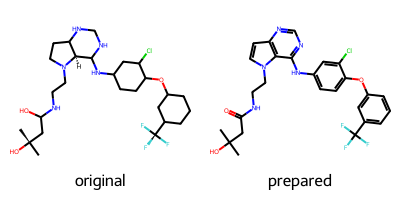

In [14]:
smiles = "CC(C)(O)CC(=O)NCCn1ccc2ncnc(Nc3ccc(Oc4cccc(c4)C(F)(F)F)c(Cl)c3)c12"
rdkit_ligand = prepare_ligand(pdb_path, ligand_name, smiles)


In [15]:
def rdkit_to_openmm(rdkit_mol, name="LIG"):
    """
    将RDKit分子转换为OpenMM分子。

    参数
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        需要转换的RDKit分子
    name: str
        分子名称

    返回值
    -------
    omm_molecule: openmm.app.Modeller
        包含目标分子的OpenMM建模器对象
    """
    # 第一步：RDKit转OpenFF
    # 直觉理解：就像将文件从一种格式转换为中间格式
    # 不这么做会怎样：无法利用OpenFF提供的功能和工具
    off_mol = Molecule.from_rdkit(rdkit_mol)

    # 第二步：设置分子名称
    # 直觉理解：给分子贴上标签，方便后续识别
    # 不这么做会怎样：在复杂体系中难以区分不同分子
    off_mol.name = name

    # 第三步：为原子添加名称
    # 直觉理解：给分子中的每个原子编号，像给团队成员分配工号
    # 不这么做会怎样：无法在模拟中追踪和区分同类型的原子
    element_counter_dict = {}
    for off_atom, rdkit_atom in zip(off_mol.atoms, rdkit_mol.GetAtoms()):
        element = rdkit_atom.GetSymbol()
        # 计数器更新或初始化
        if element in element_counter_dict.keys():
            element_counter_dict[element] += 1
        else:
            element_counter_dict[element] = 1
        # 命名格式：元素符号+编号（如C1, C2, O1等）
        off_atom.name = element + str(element_counter_dict[element])

    # 第四步：OpenFF转OpenMM
    # 直觉理解：将中间格式转换为最终需要的格式
    # 不这么做会怎样：无法在OpenMM中使用这个分子进行模拟
    off_mol_topology = off_mol.to_topology()
    mol_topology = off_mol_topology.to_openmm()
    mol_positions = off_mol.conformers[0]

    # 第五步：单位转换（埃转纳米）
    # 直觉理解：将度量单位统一到OpenMM使用的标准
    # 不这么做会怎样：模拟中的距离会差1000倍，导致完全错误的结果
    mol_positions = mol_positions.to("nanometers")

    # TODO 补丁做法，防止名字丢失
    for chain in mol_topology.chains():
        for residue in chain.residues():
            residue.name = name  # 将所有残基的名称都设置为指定的名称
    # 第六步：合并拓扑和位置信息
    # 直觉理解：将分子的"连接关系"和"空间位置"组合在一起
    # 不这么做会怎样：OpenMM无法同时知道原子如何连接以及在哪里
    omm_mol = app.Modeller(mol_topology, mol_positions)
    # 修改拓扑中的残基名称

    return omm_mol


In [16]:
omm_ligand = rdkit_to_openmm(rdkit_ligand, ligand_name)


In [17]:
def merge_protein_and_ligand(protein, ligand):
    """
    Merge two OpenMM objects.

    Parameters
    ----------
    protein: pdbfixer.pdbfixer.PDBFixer
        Protein to merge.
    ligand: openmm.app.Modeller
        Ligand to merge.

    Returns
    -------
    complex_topology: openmm.app.topology.Topology
        The merged topology.
    complex_positions: openmm.unit.quantity.Quantity
        The merged positions.
    """
    # combine topologies
    md_protein_topology = md.Topology.from_openmm(
        protein.topology
    )  # using mdtraj for protein top
    md_ligand_topology = md.Topology.from_openmm(
        ligand.topology
    )  # using mdtraj for ligand top
    md_complex_topology = md_protein_topology.join(
        md_ligand_topology
    )  # add them together
    complex_topology = md_complex_topology.to_openmm()

    # combine positions
    total_atoms = len(protein.positions) + len(ligand.positions)

    # create an array for storing all atom positions as tupels containing a value and a unit
    # called OpenMM Quantities
    complex_positions = unit.Quantity(np.zeros([total_atoms, 3]), unit=unit.nanometers)
    complex_positions[: len(protein.positions)] = (
        protein.positions
    )  # add protein positions
    complex_positions[len(protein.positions) :] = (
        ligand.positions
    )  # add ligand positions

    return complex_topology, complex_positions


In [18]:
complex_topology, complex_positions = merge_protein_and_ligand(
    prepared_protein, omm_ligand
)


/root/learn/nf-mol/.conda/lib/python3.11/site-packages/openmm/unit/quantity.py:753: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  self._value[key] = value / self.unit


In [19]:
print("Complex topology has", complex_topology.getNumAtoms(), "atoms.")
# NBVAL_CHECK_OUTPUT


Complex topology has 5561 atoms.


In [29]:
def generate_forcefield(
    rdkit_mol=None, protein_ff="amber14-all.xml", solvent_ff="amber14/tip3pfb.xml"
):
    """
    Generate an OpenMM Forcefield object and register a small molecule.

    Parameters
    ----------
    rdkit_mol: rdkit.Chem.rdchem.Mol
        Small molecule to register in the force field.
    protein_ff: string
        Name of the force field.
    solvent_ff: string
        Name of the solvent force field.

    Returns
    -------
    forcefield: openmm.app.Forcefield
        Forcefield with registered small molecule.
    """
    forcefield = app.ForceField(protein_ff, solvent_ff)

    if rdkit_mol is not None:
        gaff = GAFFTemplateGenerator(
            molecules=Molecule.from_rdkit(rdkit_mol, allow_undefined_stereo=True)
        )
        forcefield.registerTemplateGenerator(gaff.generator)

    return forcefield


In [30]:
forcefield = generate_forcefield(rdkit_ligand)

forcefield


In [31]:
modeller = app.Modeller(complex_topology, complex_positions)
modeller.addSolvent(
    forcefield,
    padding=1.0 * unit.nanometers,
    ionicStrength=0.15 * unit.molar,
)


In [32]:
system = forcefield.createSystem(modeller.topology, nonbondedMethod=app.PME)
integrator = mm.LangevinIntegrator(
    300 * unit.kelvin, 1.0 / unit.picoseconds, 2.0 * unit.femtoseconds
)
simulation = app.Simulation(modeller.topology, system, integrator)
simulation.context.setPositions(modeller.positions)


In [33]:
simulation.minimizeEnergy()
with open(DATA / "topology.pdb", "w", encoding="utf-8") as pdb_file:
    app.PDBFile.writeFile(
        simulation.topology,
        simulation.context.getState(
            getPositions=True, enforcePeriodicBox=True
        ).getPositions(),
        file=pdb_file,
        keepIds=True,
    )


In [34]:
steps = 5000  # corresponds to 100 ps
write_interval = 10  # write every 10 ps
log_interval = 250  # log progress to stdout every 5 ps
simulation.reporters.append(
    md.reporters.XTCReporter(
        file=str(DATA / "trajectory.xtc"), reportInterval=write_interval
    )
)
simulation.reporters.append(
    app.StateDataReporter(
        sys.stdout,
        log_interval,
        step=True,
        potentialEnergy=True,
        temperature=True,
        progress=True,
        remainingTime=True,
        speed=True,
        totalSteps=steps,
        separator="\t",
    )
)

In [35]:
simulation.context.setVelocitiesToTemperature(300 * unit.kelvin)
simulation.step(steps)  # perform the simulation


#"Progress (%)"	"Step"	"Potential Energy (kJ/mole)"	"Temperature (K)"	"Speed (ns/day)"	"Time Remaining"
5.0%	250	-827939.1255635219	209.43858820855064	0	--
10.0%	500	-810174.0246594195	243.0936109976461	6.88	1:53
15.0%	750	-800101.743558538	264.20339880525376	6.96	1:45
20.0%	1000	-794300.5796360094	279.1073108605095	6.54	1:45
25.0%	1250	-788846.8282844598	286.8088525172999	6.61	1:38
30.0%	1500	-784673.1845940044	291.44526630241444	6.68	1:30
35.0%	1750	-782685.5554337631	292.641440562936	6.71	1:23
40.0%	2000	-781461.0788409876	295.54979896652975	6.74	1:16
45.0%	2250	-781097.6930166034	296.3472839573262	6.6	1:12
50.0%	2500	-779674.6816931149	298.1924270253502	6.63	1:05
55.0%	2750	-779326.4547566933	298.5355128251709	6.64	0:58
60.0%	3000	-778610.16425615	297.49144365172236	6.66	0:51
65.0%	3250	-778782.6703951452	299.1833458060493	6.68	0:45
70.0%	3500	-778028.5120269947	298.35426491146524	6.6	0:39
75.0%	3750	-778373.8677333844	298.0618567920522	6.62	0:32
80.0%	4000	-777252.9794198879	298.1